### Проект 3. О вкусной и здоровой пище ¶
#### Исполнитель: Богданова Юлия
#### Группа: SF-DST-34

![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
from datetime import datetime, timedelta

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
41620,id_1649,Amsterdam,NaN,1654.0,NaN,15.0,"[['PERFECT!', 'Very cozy and delicious!'], ['1...",/Restaurant_Review-g188590-d7973209-Reviews-Ko...,d7973209,1,4.5
33855,id_107,Lyon,NaN,108.0,NaN,419.0,"[['Doesn’t Quite Make It', '5 star meal'], ['1...",/Restaurant_Review-g187265-d1085863-Reviews-Le...,d1085863,1,4.5
49717,id_1223,Edinburgh,NaN,1224.0,NaN,2.0,"[['Great Food'], ['07/22/2015']]",/Restaurant_Review-g186525-d8471870-Reviews-Co...,d8471870,1,5.0
3867,id_3867,Hamburg,NaN,1484.0,NaN,6.0,"[['Nice, new place with decent burgers.'], ['0...",/Restaurant_Review-g187331-d12452365-Reviews-H...,d12452365,0,0.0
4649,id_4649,Madrid,NaN,4503.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d991375-Reviews-Ela...,d991375,0,0.0


In [14]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 0. Предобработка данных

In [15]:
# Приведем названия признаrов к нижнему регистру

df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking',
              'price_range', 'number_of_reviews', 'reviews',
              'url_ta', 'id_ta', 'sample', 'rating']

In [16]:
# Определим функцию основных сведений о признаке

def column_info(column):
    print('Количество пустых значений в столбце:', (df[column].isnull()).sum(), '\n')
    print('Процент непустых/пустых значений в столбце: \n', df[column].isnull().value_counts(normalize=True)*100, '\n')
    print('Количество уникальных значений:', df[column].nunique(), '\n')
    print('Количество вхождений каждого значения: \n', df[column].value_counts(), '\n')    
    return

In [17]:
# Первичный отсмотр данных

df.isnull().any()

# Видно, что три признака содержат пустые значения

restaurant_id        False
city                 False
cuisine_style         True
ranking              False
price_range           True
number_of_reviews     True
reviews               True
url_ta               False
id_ta                False
sample               False
rating               False
dtype: bool

In [18]:
# Посмотрим, сколько столбцов являются числовыми
df.select_dtypes(include=["float", 'int'])

,ranking,number_of_reviews,sample,rating
0,12963.0,4.0,0,0.0
1,106.0,97.0,0,0.0
2,810.0,28.0,0,0.0
3,1669.0,202.0,0,0.0
4,37.0,162.0,0,0.0
...,...,...,...,...
49995,500.0,79.0,1,4.5
49996,6341.0,542.0,1,3.5
49997,1652.0,4.0,1,4.5
49998,641.0,70.0,1,4.0


In [19]:
# Типы всех признаков
df.apply(lambda x: type(x[0]))

restaurant_id          <class 'str'>
city                   <class 'str'>
cuisine_style          <class 'str'>
ranking              <class 'float'>
price_range            <class 'str'>
number_of_reviews    <class 'float'>
reviews                <class 'str'>
url_ta                 <class 'str'>
id_ta                  <class 'str'>
sample                 <class 'int'>
rating               <class 'float'>
dtype: object

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [20]:
# Столбец Number of Reviews
df['number_of_reviews_isNaN'] = pd.isna(df['number_of_reviews']).astype('uint8')

In [21]:
df['number_of_reviews_isNaN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: number_of_reviews_isNaN, Length: 50000, dtype: uint8

In [22]:
# Аналогично остальные признаки с NaN
df['price_range_isNaN'] = pd.isna(df['price_range']).astype('uint8')
df['cuisine_style_isNaN'] = pd.isna(df['cuisine_style']).astype('uint8')

# В признаке reviews есть и NaN, и значения вида '[[], []]'. Включим оба пропуска
df['reviews'] = df['reviews'].fillna('[[], []]')
df['reviews_isNaN'] = df['reviews'].apply(lambda x: 1 if x == '[[], []]' else 0)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [23]:
df.nunique(dropna=False)

restaurant_id              13094
city                          31
cuisine_style              10732
ranking                    12975
price_range                    4
number_of_reviews           1574
reviews                    41857
url_ta                     49963
id_ta                      49963
sample                         2
rating                        10
number_of_reviews_isNaN        2
price_range_isNaN              2
cuisine_style_isNaN            2
reviews_isNaN                  2
dtype: int64

### restaurant_id

In [24]:
column_info('restaurant_id')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: restaurant_id, dtype: float64 

Количество уникальных значений: 13094 

Количество вхождений каждого значения: 
 id_633      19
id_227      19
id_871      19
id_436      19
id_71       18
            ..
id_15001     1
id_4352      1
id_14157     1
id_11595     1
id_6902      1
Name: restaurant_id, Length: 13094, dtype: int64 



### city

In [25]:
column_info('city')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: city, dtype: float64 

Количество уникальных значений: 31 

Количество вхождений каждого значения: 
 London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64 



### cuisine_style

In [26]:
column_info('cuisine_style')

Количество пустых значений в столбце: 11590 

Процент непустых/пустых значений в столбце: 
 False    76.82
True     23.18
Name: cuisine_style, dtype: float64 

Количество уникальных значений: 10731 

Количество вхождений каждого значения: 
 ['Italian']                                                                                                       1332
['French']                                                                                                        1019
['Spanish']                                                                                                        860
['French', 'European']                                                                                             503
['Cafe']                                                                                                           500
                                                                                                                  ... 
['Japanese', 'Sushi', 'Asian', 'International

In [27]:
# Посчитаем количество уникальных значений кухонь и число вхождений каждой, предварительно заменив пустые значения на 'noinfo'
cuisine_style = df['cuisine_style'].fillna('noinfo')

pattern = re.compile('\w+\s*[&]*\s*\w*\s*\w*')
cuisine_style = cuisine_style.apply(lambda x: pattern.findall(x))
cuisine_list = cuisine_style.explode().value_counts()

print(len(cuisine_list) - 1)
print(cuisine_list)

125
Vegetarian Friendly    14021
European               12561
noinfo                 11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Salvadoran                 1
Latvian                    1
Xinjiang                   1
Burmese                    1
Name: cuisine_style, Length: 126, dtype: int64


In [28]:
# Посчитаем среднее количество кухонь
cuisine_number = cuisine_style.apply(lambda x: len(x) if x != 'noinfo' else 1)
print(cuisine_number.mean())

2.62532


In [29]:
# Во избежание дальнейших ошибок заменим NaN значения на самую популярную кухню
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: x if isinstance (x, str) else str(['Vegetarian Friendly']))

### ranking

In [30]:
column_info('ranking')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: ranking, dtype: float64 

Количество уникальных значений: 12975 

Количество вхождений каждого значения: 
 93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: ranking, Length: 12975, dtype: int64 



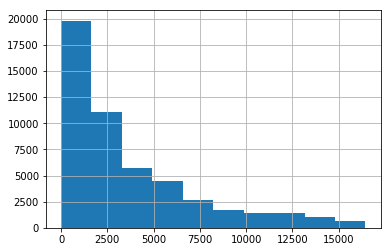

In [31]:
# Визуально оценим присутствуют ли выбросы
df['ranking'].hist()

### price_range

In [32]:
column_info('price_range')

Количество пустых значений в столбце: 17361 

Процент непустых/пустых значений в столбце: 
 False    65.278
True     34.722
Name: price_range, dtype: float64 

Количество уникальных значений: 3 

Количество вхождений каждого значения: 
 $$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64 



In [33]:
# Заменим пустые значения средним ценовым сегментом
df['price_range'] = df['price_range'].fillna('$$ - $$$')

In [34]:
# Перекодируем признак из строкового в дискретный
df['price_range'] = df['price_range'].apply(lambda x: 1 if x == '$' else (2 if x == '$$ - $$$' else 3))
df.head(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_isNaN,price_range_isNaN,cuisine_style_isNaN,reviews_isNaN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,0


### number_of_reviews

In [35]:
column_info('number_of_reviews')

Количество пустых значений в столбце: 3200 

Процент непустых/пустых значений в столбце: 
 False    93.6
True      6.4
Name: number_of_reviews, dtype: float64 

Количество уникальных значений: 1573 

Количество вхождений каждого значения: 
 2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number_of_reviews, Length: 1573, dtype: int64 



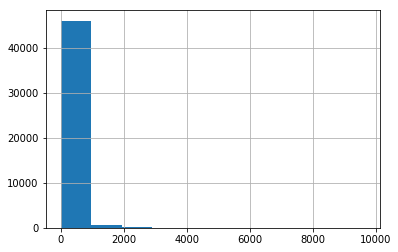

In [36]:
# Визуально оценим присутствуют ли выбросы
df['number_of_reviews'].hist()

In [37]:
# Заменим NaNs на часто встречающееся количество отзывов
df['number_of_reviews'] = df['number_of_reviews'].fillna(2)

### reviews

In [38]:
column_info('reviews')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: reviews, dtype: float64 

Количество уникальных значений: 41857 

Количество вхождений каждого значения: 
 [[], []]                                                                                                                         8114
[['Fantastic food, Excellent service', 'Surprising good Indian food in Spain'], ['01/07/2018', '11/08/2017']]                       2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                                             2
[['Delicious'], ['06/06/2017']]                                                                                                     2
[['Excellent'], ['09/03/2015']]                                                                                                     2
                                                                                                                  

### url_ta

In [39]:
column_info('url_ta')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: url_ta, dtype: float64 

Количество уникальных значений: 49963 

Количество вхождений каждого значения: 
 /Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                       2
/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html                  2
/Restaurant_Review-g187514-d1568045-Reviews-Restaurante_Lateral_Santa_Ana-Madrid.html    2
/Restaurant_Review-g187514-d4748208-Reviews-Restaurante_Te_Oriental-Madrid.html          2
/Restaurant_Review-g187514-d9877640-Reviews-Raku_Sushi-Madrid.html                       2
                                                                                        ..
/Restaurant_Review-g186338-d10352833-Reviews-Al_Chile-London_England.html                1
/Restaurant_Review-g188644-d8517129-Reviews-Taverne_Omega-Brussels.html                  1
/Restaurant_Review-g186338-d5815452-Reviews-Snr_Ceviche-L

### id_ta

In [40]:
column_info('id_ta')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: id_ta, dtype: float64 

Количество уникальных значений: 49963 

Количество вхождений каждого значения: 
 d5617412     2
d8753348     2
d10316215    2
d11698990    2
d1028622     2
            ..
d9702108     1
d7199748     1
d4769028     1
d8677564     1
d4926993     1
Name: id_ta, Length: 49963, dtype: int64 



Таким образом, категориальными являются следующие признаки:
- city ->  из него можно сделать dummies-переменные
- cuisine_style -> отсюда можно достать несколько признаков
- reviews -> можно создать несколько новых категориальных и числовых переменных
- url_ta и id_ta также категориальные признаки, из которых можно достать коды

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [41]:
# Преобразуем признак 'city' в get_dummies-переменные в самом конце

### Признак restaurant_id

In [42]:
# Является ли ресторан сетевым? Если да, то насколько большая сеть - создадим четыре новых признака
restaurant_id = dict(df['restaurant_id'].value_counts())

df['single_restaurant'] = df['restaurant_id'].apply(lambda x: 1 if restaurant_id[x] == 1 else 0)
df['small_restaurant_chain'] = df['restaurant_id'].apply(lambda x: 1 if 2 <= restaurant_id[x] <= 7 else 0)
df['medium_restaurant_chain'] = df['restaurant_id'].apply(lambda x: 1 if 8 <= restaurant_id[x] <= 13 else 0)
df['large_restaurant_chain'] = df['restaurant_id'].apply(lambda x: 1 if restaurant_id[x] > 13 else 0)

### Признак cuisine_style

In [43]:
# Создадим столбец с количеством кухонь для каждого ресторана
df['cuisine_number'] = cuisine_number

In [44]:
# Определим среднее количество кухонь в городе
mean_cousines = df.groupby(['city'])['cuisine_number'].mean()
print(mean_cousines)

city
Amsterdam     3.321429
Athens        2.613402
Barcelona     2.679234
Berlin        2.276525
Bratislava    2.228947
Brussels      2.502283
Budapest      3.278159
Copenhagen    2.705739
Dublin        3.319378
Edinburgh     3.734228
Geneva        2.600000
Hamburg       1.936762
Helsinki      2.627368
Krakow        3.138989
Lisbon        2.656345
Ljubljana     3.405405
London        2.969137
Luxembourg    2.741445
Lyon          1.636767
Madrid        2.106740
Milan         2.477728
Munich        2.459389
Oporto        2.721184
Oslo          3.086066
Paris         2.141945
Prague        2.854075
Rome          3.194670
Stockholm     2.511133
Vienna        2.742897
Warsaw        2.566486
Zurich        3.010219
Name: cuisine_number, dtype: float64


In [45]:
# Классифицируем города по их среднему количеству кухонь
mean_cuisines_list = dict(df.groupby(['city'])['cuisine_number'].mean())

df['mean_cuisines<2'] = df['city'].apply(lambda x: 1 if mean_cuisines_list[x] < 2 else 0)
df['2<=mean_cuisines<=3'] = df['city'].apply(lambda x: 1 if 2 <= mean_cuisines_list[x] <= 3 else 0)
df['mean_cuisines>3'] = df['city'].apply(lambda x: 1 if mean_cuisines_list[x] > 3 else 0)

In [46]:
# Опеределим популярной/непопулярной/средней популярности кухней славится ресторан

# Приведем стобец кухонь к удобному виду, заменив строки на списки
pattern = re.compile('\w+\s*[&]*\s*\w*\s*\w*')
cuisine_style = df['cuisine_style'].apply(lambda x: pattern.findall(x))
df['cuisine_style'] = cuisine_style

# Создадим три новых признака
popular_cuisines = list(cuisine_list.index[0:42])
df['popular_cuisine'] = df['cuisine_style'].apply(lambda x: 1 if any(cuisine in x for cuisine in popular_cuisines) else 0)

rare_cuisines = list(cuisine_list.index[-41:])
df['rare_cuisine'] = df['cuisine_style'].apply(lambda x: 1 if any(cuisine in x for cuisine in rare_cuisines) else 0)

middle_frequency_cuisines = list(cuisine_list.index[42:84])
df['middle_frequency_cuisine'] = df['cuisine_style'].apply(lambda x: 1 if any(cuisine in x for cuisine in middle_frequency_cuisines) else 0)

### Признак ranking

In [47]:
# Определим средний рейтинг ресторанов в городе
mean_ranking = dict(df.groupby(['city'])['ranking'].mean())

In [48]:
# Классифицируем рестораны по рейтингу (выше или ниже среднего?)
ranking_more_mean = []

for i in range(len(df['city'])):
    if df['ranking'][i] > mean_ranking[df['city'][i]]:
        ranking_more_mean.append(1)
    else:
        ranking_more_mean.append(0)
        
df['ranking>mean'] = ranking_more_mean

### Признак reviews

In [49]:
# Достанем даты из признака
pattern = re.compile('\'\d+\/\d+\/\d+\'?')
reviews_dates = df['reviews'].apply(lambda x: pattern.findall(x))

# Переведем даты в формат datetime
reviews_dates = reviews_dates.apply(lambda x: [datetime.strptime(item, "'%m/%d/%Y'") for item in x])
print(reviews_dates)

0                                                []
1        [2017-12-05 00:00:00, 2017-10-29 00:00:00]
2        [2017-12-28 00:00:00, 2017-12-06 00:00:00]
3        [2017-12-06 00:00:00, 2017-11-22 00:00:00]
4        [2018-02-08 00:00:00, 2018-01-24 00:00:00]
                            ...                    
49995    [2017-12-16 00:00:00, 2017-11-12 00:00:00]
49996    [2017-12-21 00:00:00, 2017-12-12 00:00:00]
49997    [2016-11-03 00:00:00, 2008-04-12 00:00:00]
49998    [2017-07-11 00:00:00, 2017-06-18 00:00:00]
49999    [2016-01-31 00:00:00, 2012-07-04 00:00:00]
Name: reviews, Length: 50000, dtype: object


In [50]:
# Определим интервал между датами ревью и сформируем соответствующий признак.
# Пропуски пока оставим - в дальнейшем можно будет подобрать, чем лучше их заполнить.
# Если дата одна - ставим 0
date_interval = [None]*len(reviews_dates)

for i in range(0, len(reviews_dates)):
    if len(reviews_dates[i]) > 1:
        date_interval[i] = abs(reviews_dates[i][1] - reviews_dates[i][0]).days
    elif len(reviews_dates[i]) == 1:
        date_interval[i] = 0

df['review_interval'] = date_interval

In [51]:
# Вычислим как давно был оставлен последний отзыв, т.е. насколько свеж отзыв (в днях) и добавим инфо в признак.
# Пропуски пока сохраняем
date_fresh = [None]*len(reviews_dates)

for i in range(0, len(reviews_dates)):
    if len(reviews_dates[i]) > 1:
        date_fresh[i] = (datetime.now() - max(reviews_dates[i])).days
    elif len(reviews_dates[i]) == 1:
        date_fresh[i] = (datetime.now() - reviews_dates[i][0]).days
        
df['review_freshness'] = date_fresh

In [52]:
# Добавим день недели каждого отзыва.
# Заполнить пропуски можно самым часто встречающимся значением

# Для этого вычислим в какой день недели чаще всего пишут отзывы 
week_day_crop = []

for i in range(0, len(reviews_dates)):
    if len(reviews_dates[i]) > 0:
        for date in reviews_dates[i]:
            week_day_crop.append(date.weekday())
            
print(pd.Series(week_day_crop).value_counts())

6    12090
2    11776
5    11372
1    11188
0    11140
3    10318
4    10208
dtype: int64


In [53]:
# Чаще всего пишут отзывы в воскресенье, однако, значение среды на втором месте

# Сформируем соответствующие признаки, добавив в случае одной даты день недели - воскресенье
week_day_1 = [None]*len(reviews_dates)
week_day_2 = [None]*len(reviews_dates)

for i in range(0, len(reviews_dates)):
    if len(reviews_dates[i]) > 1:
        week_day_1[i] = reviews_dates[i][0].weekday()
        week_day_2[i] = reviews_dates[i][1].weekday()
    elif len(reviews_dates[i]) == 1:
        week_day_1[i] = reviews_dates[i][0].weekday()
        week_day_2[i] = 6
        
df['weekday_rev1'] = week_day_1
df['weekday_rev2'] = week_day_2

In [54]:
# Оставшиеся пропуски заменим на второе часто встречающее значение - среда
df['weekday_rev1'] = df['weekday_rev1'].fillna(2)
df['weekday_rev2'] = df['weekday_rev2'].fillna(2)

In [55]:
# Пришло время заполнить пустоты в интервале между датами и в признаке "свежесть отзыва"
# Между средним значением и 0, лучший результат был получен при 0
df['review_interval'] = df['review_interval'].fillna(0)
df['review_freshness'] = df['review_freshness'].fillna(0)

In [56]:
# Сформируем данные о характере отзывов
positive = ['good', 'perfect', 'well', 'fine', 'comfort', 'satisfactory', 'great',
            'nice', 'wonderful', 'okay', 'tasty', 'delicious', 'luscious', 'yummy',
            'appetizing', 'comfortable', 'ease', 'luxury', 'benefit', 'convenience', 'pleasant'
            'friendly', 'excellent', 'best']

negative = ['bad', 'awful', 'terrible', 'unnormal', 'stuffily', 'tightly',
            'unpleasant', 'horrible', 'unsatisfactory', 'sad', 'slow', 'ugly', 'expensive']

df['positive_review'] = df['reviews'].apply(lambda x: 1 if any(word in x for word in positive) else 0)
df['negative_review'] = df['reviews'].apply(lambda x: 1 if any(word in x for word in negative) else 0)

### Признак url_ta

In [57]:
# Вытащим url код в отдельную переменную
df['url_ta_code']= df['url_ta'].str.split('-').apply(lambda x: x[1][1:])

### Признак id_ta

In [58]:
# Вычленим числовой идентификатор в отдельный столбец
df['id_ta_code']= df['id_ta'].apply(lambda x: x[1:])

### Признак city 

In [59]:
# Создадим признак с величиной населения городов
population = {'Paris': 2140526, 'Stockholm': 961609, 'London': 8787892, 'Berlin': 3601131, 'Munich': 1456039, 'Oporto': 221800,
       'Milan': 1366180, 'Bratislava': 437725, 'Vienna': 1840573, 'Rome':2872800, 'Barcelona':  1620343, 'Madrid': 3223334,
       'Dublin' : 553165, 'Brussels' : 1198726, 'Zurich' : 434008, 'Warsaw' : 1702139, 'Budapest' : 1752286, 'Copenhagen' : 615993,
       'Amsterdam' : 859732, 'Lyon' : 515695, 'Hamburg' : 1830584, 'Lisbon': 553000, 'Prague' : 1280508, 'Oslo' : 673469,
       'Helsinki' : 643272, 'Edinburgh': 513210 , 'Geneva': 201818, 'Ljubljana' : 284355, 'Athens' : 655780,
       'Luxembourg' : 122273, 'Krakow' : 779115}

df['population'] = df['city'].apply(lambda x: population[x])

In [60]:
# Прежде, чем добавить dummies-переменные, сохраним базовый вариант сэмпла
# в отдельную переменную,чтобы в дальнейшем было проще визуально исследовать
# матрицу корреляций
df_principal = df

# Теперь добавим dummies-переменные
df = pd.concat([df, pd.get_dummies(df['city'])], axis=1)

In [61]:
# Создадим новый признак из ranking и population, потому что ranking
# имеет нормальное распределение, просто в больших городах больше ресторанов,
# из-за этого имеется смещение.
# Умножаем его на 1000, чтобы числа были ближе к целому значению
df['ranking_ratio']= df['ranking'] / df['population']*1000

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Предпроверка

In [62]:
# Удостоверимся в отсутствии пустых значений в сэмпле
pd.options.display.max_rows = 65
df.isnull().any()

restaurant_id    False
city             False
cuisine_style    False
ranking          False
price_range      False
                 ...  
Stockholm        False
Vienna           False
Warsaw           False
Zurich           False
ranking_ratio    False
Length: 68, dtype: bool

### Посмотрим распределение признака

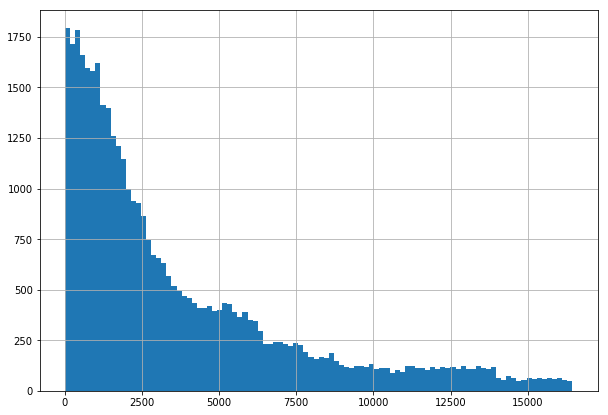

In [63]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

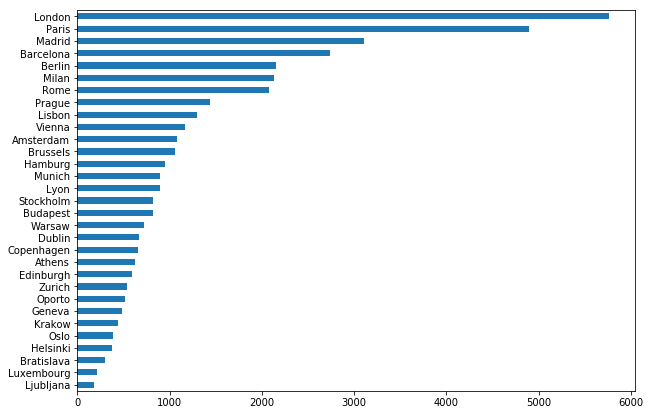

In [64]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

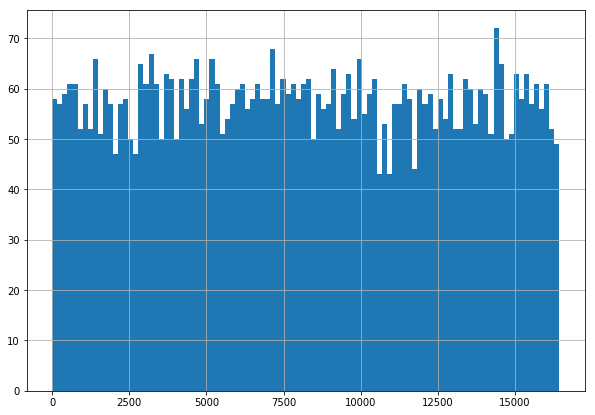

In [65]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

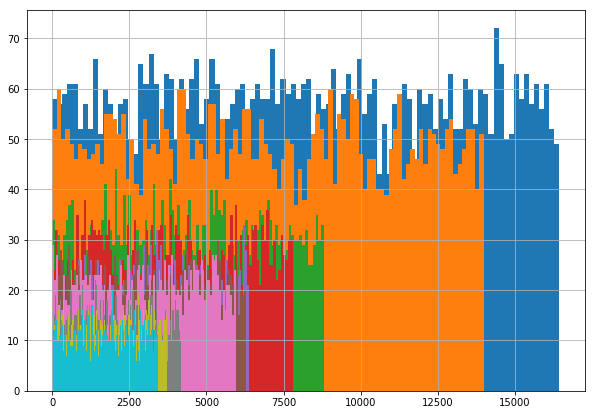

In [66]:
# Посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

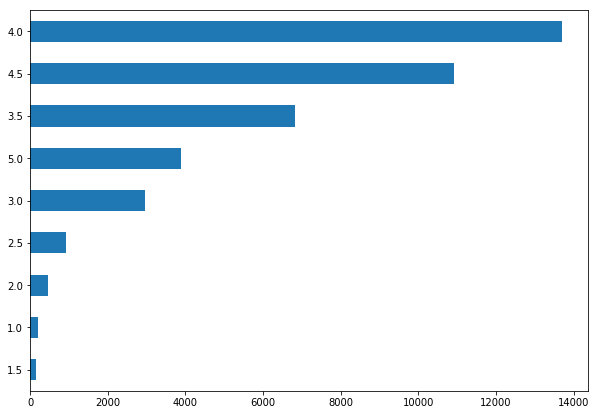

In [67]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

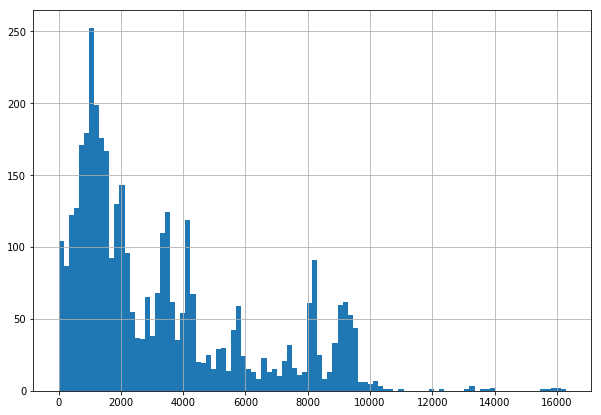

In [68]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

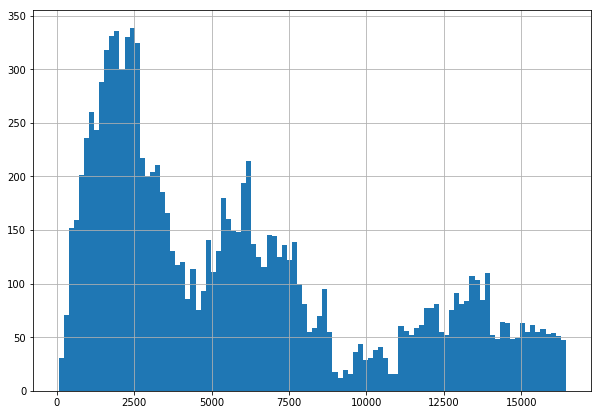

In [69]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков

Поможет понять, как признаки связаны между собой и целевой.

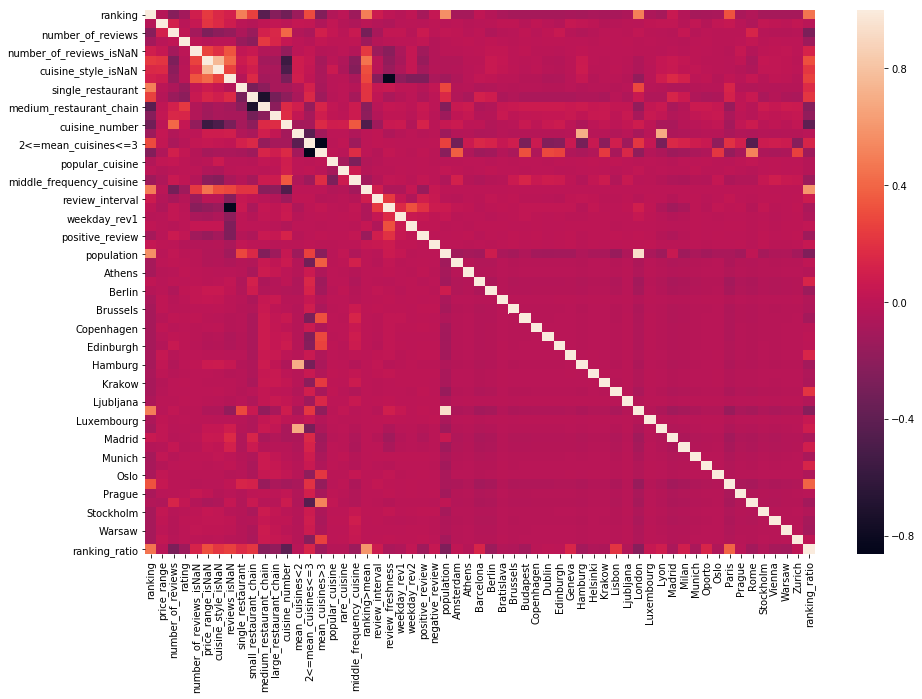

In [70]:
# Полный датасет
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

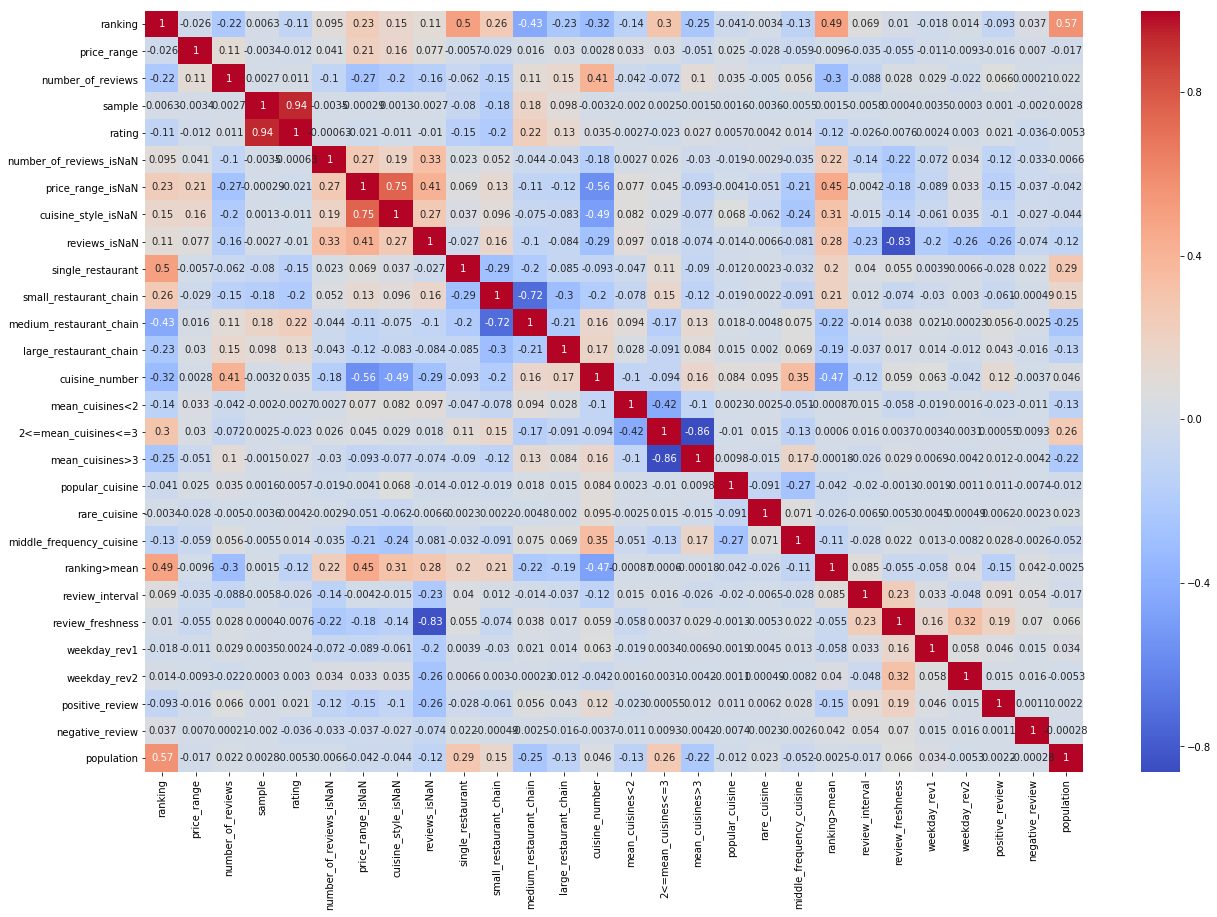

In [71]:
# Видно, что в области dummies-переменных нет выделяющихся цветов. Посмотрим на коэффициенты
# корреляции на графике, используя сэмпл без городов
correlation = df_principal.corr()
plt.figure(figsize=(21, 14))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [72]:
# Удаление следующих признаков незначительно улучшило результат
df = df.drop(['mean_cuisines>3', 'reviews_isNaN', 'price_range_isNaN'], axis=1)

In [73]:
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating',
       'number_of_reviews_isNaN', 'cuisine_style_isNaN', 'single_restaurant',
       'small_restaurant_chain', 'medium_restaurant_chain',
       'large_restaurant_chain', 'cuisine_number', 'mean_cuisines<2',
       '2<=mean_cuisines<=3', 'popular_cuisine', 'rare_cuisine',
       'middle_frequency_cuisine', 'ranking>mean', 'review_interval',
       'review_freshness', 'weekday_rev1', 'weekday_rev2', 'positive_review',
       'negative_review', 'url_ta_code', 'id_ta_code', 'population',
       'Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels',
       'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg',
       'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
       'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris',
       'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsa

# Data Preprocessing
Для удобства и воспроизводимости кода можно завернуть всю обработку в одну большую функцию.

In [74]:
# См. выше
# # на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [75]:
# См. выше
# def preproc_data(df_input):
#     '''includes several functions to pre-process the predictor data.'''
    
#     df_output = df_input.copy()
    
#     # ################### 1. Предобработка ############################################################## 
#     # убираем не нужные для модели признаки
#     #df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
#     df_output.drop(['ID_TA','URL_TA'], axis = 1, inplace=True)
    
#     # ################### 2. NAN ############################################################## 
#     # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    
#     # тут ваш код по обработке NAN
#     df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(round(df_output.groupby('City')['Number of Reviews'].transform('mean')))
#     # Ваша обработка 'Price Range'
#     df_output['Price Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
#     df_output['Price Range_isNAN']
#     price_mode = df_output['Price Range'].value_counts().index[0]
#     df_output['Price Range'].fillna(price_mode, inplace=True)
#     import requests
#     import json

#     def get_city_opendata(city):
#         tmp = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q=%s&sort=population'
#         cmd = tmp % (city)
#         res = requests.get(cmd)
#         dct = json.loads(res.content)
#         out = dct['records'][0]['fields']
#         #return type(out)
#         if 'population' in out.keys():
#             return out['population']
#         else:
#             return None

#     tmp = df_output.groupby(['City']).count()

#     tmp['City'] = tmp.index
#     tmp['City_Population'] = tmp['City'].apply(lambda x: get_city_opendata(x))

#     #Тут можно вставить fillna вручную, потому что не получилось автоматически заполнить население Кракова, Люксембурга и Опорто
#     tmp.at['Krakow', 'City_Population'] = 779115
#     tmp.at['Oporto', 'City_Population'] = 249633
#     tmp.at['Luxemburg', 'City_Population'] = 626108

#     city_columns = [s for s in tmp.columns if ('City_Population' in s) == False]
#     city_columns
#     tmp.drop(city_columns, axis = 1, inplace=True)

#     df_output = df_output.merge(tmp, how='inner', on='City')
#     df_output.at['Krakow', 'City_Population'] = 779115
#     df_output.at['Oporto', 'City_Population'] = 249633
#     df_output.at['Luxemburg', 'City_Population'] = 626108
#     df_output['City_Population'] = df_output['City_Population'].fillna(df_output['City_Population'].mean())

    
#     # ################### 3. Encoding ############################################################## 
#     # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#     df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
#     # тут ваш код не Encoding фитчей
#     def price(s):
#         if s == '$':
#             return 1
#         elif s == '$$ - $$$':
#             return 2
#         elif s == '$$$$':
#             return 3
#         else:
#             return 0

#     df_output['Price Range']= df_output['Price Range'].apply(lambda x: price(x))
    
#     values = {'Cuisine Style': '',}
#     df_output = df_output.fillna(value=values)
#     df_output['Cuisine'] = df_output['Cuisine Style'].apply(lambda x: x.lower().replace(" ","").replace("'","").replace("[","").replace("]","").split(','))

#     df_output = df_output.join(pd.get_dummies(df_output.Cuisine.apply(pd.Series).stack()).sum(level=0))
    
    
#     # ################### 4. Feature Engineering ####################################################
#     # тут ваш код не генерацию новых фитчей
#     import re
#     from datetime import datetime
#     pattern = re.compile('\d+\W\d+\W\d\d\d\d')
#     df_output['date_anons'] = df_output['Reviews'].apply(lambda x: pattern.findall(str(x)))
#     df_output['date_anons']


#     df_output.head(15)
#     def days(lst):
#         if len(lst)<2:
#             return 0
#         return (pd.to_datetime(lst[0]) - pd.to_datetime(lst[1])).days
#     df_output['days']= df_output['date_anons'].apply(lambda x: abs(days(x)))
    
#     df_output['Ranking Ratio']= df_output['Ranking']/df_output['City_Population']*1000
#     # ################### 5. Clean #################################################### 
#     # убираем признаки которые еще не успели обработать, 
#     # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#     object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
#     #df_output.drop(object_columns, axis = 1, inplace=True)
#     df_output.drop(['Price Range_isNAN'], axis = 1, inplace=True)
#     # Я пробовала удалить столбцы 'City_London','City_Ljubljana','City_Prague','City_Budapest','japanese','pub', так как у них 
#     #большая корреляция с похожими признаками, но без них MAE получалось выше
#     return df_output

#### Запускаем и проверяем что получилось

In [76]:
# Обработанный датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 65 columns):
restaurant_id               50000 non-null object
city                        50000 non-null object
cuisine_style               50000 non-null object
ranking                     50000 non-null float64
price_range                 50000 non-null int64
number_of_reviews           50000 non-null float64
reviews                     50000 non-null object
url_ta                      50000 non-null object
id_ta                       50000 non-null object
sample                      50000 non-null int64
rating                      50000 non-null float64
number_of_reviews_isNaN     50000 non-null uint8
cuisine_style_isNaN         50000 non-null uint8
single_restaurant           50000 non-null int64
small_restaurant_chain      50000 non-null int64
medium_restaurant_chain     50000 non-null int64
large_restaurant_chain      50000 non-null int64
cuisine_number              50000 non-null int

In [77]:
# Модель с признаками типа "object" обучаться не будет, поэтому их необходимо удалить
# Создаем сэмпл с числовыми столбцами исходного датафрейма
df_preproc = df.select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8'])

In [78]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [79]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [80]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 56), (40000, 56), (40000, 55), (32000, 55), (8000, 55))

# Model 
Сам ML

In [81]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [82]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [83]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [84]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20608374999999998


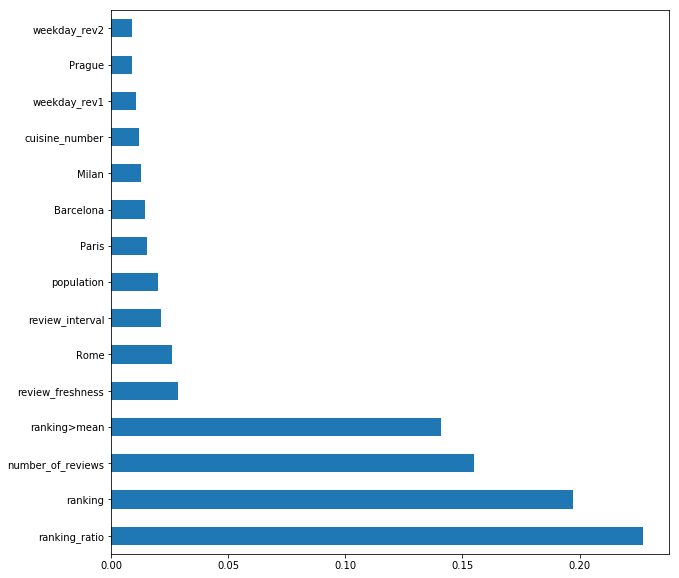

In [85]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [86]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,number_of_reviews_isNaN,cuisine_style_isNaN,single_restaurant,small_restaurant_chain,medium_restaurant_chain,large_restaurant_chain,...,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,ranking_ratio
2119,7705.0,2,7.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.876775
3771,3606.0,1,274.0,0.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1.255221
7950,16005.0,2,2.0,0.0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.821256
6991,41.0,2,773.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.023398
6802,1138.0,2,10.0,0.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2.217416
1966,1117.0,2,2.0,0.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.736435
6300,2751.0,2,16.0,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.974684
4844,330.0,1,61.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.643012
8834,1188.0,1,19.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2.303687
1911,6450.0,2,13.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.980639


In [87]:
test_data = test_data.drop(['rating'], axis=1)

In [88]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [89]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [90]:
predict_submission

array([3.035, 4.235, 4.435, ..., 2.98 , 4.545, 4.29 ])

In [91]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.035
1,id_1,4.235
2,id_2,4.435
3,id_3,4.280
4,id_4,4.410
5,id_5,4.330
6,id_6,1.580
7,id_7,2.880
8,id_8,4.055
9,id_9,4.605
